In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf
plt.style.use('ggplot')

### Data Preprocessing

In [3]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

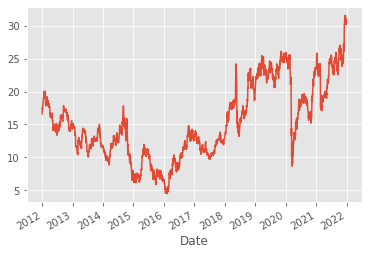

In [4]:
# Loading the dataset
#p = '10y'
#i = '1d'

df = yf.download(tickers='petr3.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [5]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.982913
High         0.984594
Low          0.983957
Close        0.985268
Adj Close    1.000000
Volume       0.002942
Name: Adj Close, dtype: float64

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,23.129999,23.610001,22.740000,23.209999,16.632433,3758200
2012-01-03,23.209999,24.020000,23.209999,24.020000,17.345388,5402100
2012-01-04,23.799999,24.280001,23.570000,24.170000,17.453705,4588400
2012-01-05,24.100000,24.309999,23.760000,24.020000,17.345388,7905400
2012-01-06,24.100000,24.350000,23.910000,24.000000,17.330944,3454500
...,...,...,...,...,...,...
2021-12-23,30.350000,30.680000,30.180000,30.440001,30.440001,6243500
2021-12-27,30.440001,31.230000,30.240000,31.040001,31.040001,17868100
2021-12-28,31.260000,31.469999,31.000000,31.059999,31.059999,8078000


In [7]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df.shape

count    2.463000e+03
mean     1.395870e+07
std      1.288061e+07
min      1.610000e+04
25%      7.240400e+06
50%      1.084730e+07
75%      1.654765e+07
max      3.104194e+08
Name: Volume, dtype: float64


(2463, 6)

# Variáveis externas

In [8]:
def consulta_selic(ultimos):
  url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados/ultimos/{}?formato=json'.format(ultimos)
     #'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=01/01/2012&dataFinal=31/12/2021'
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [9]:
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Adj Close'] + df['High']).div(3).values
    return df.assign(Vwap=(tp * v).cumsum() / v.cumsum())

In [10]:
# Dollar Brasileiro
df_dollar = yf.download(tickers=['USDBRL=x'], start="2012-01-01", end="2021-12-31")
# SP500
df_sp500 = yf.download(tickers=['SPY'], start="2012-01-01", end="2021-12-31")
# Ibovespa
df_ibov = yf.download(tickers=['^BVSP'], start="2012-01-01", end="2021-12-31")
#Petroleo da China
df_ptr = yf.download(tickers=['PTR'], start="2012-01-01", end="2021-12-31")
#Petroleo Brasil
df_pbr = yf.download(tickers=['PBR'], start="2012-01-01", end="2021-12-31")
#Dow Jones Industrial
df_dji = yf.download(tickers=['^DJI'], start="2012-01-01", end="2021-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
df_petr = yf.download(tickers='petr3.sa', start="2012-01-01", end="2021-12-31")
df_petr.drop(df_petr[df_petr['Volume']==0].index, inplace = True)
print(df_petr.shape)
#Calculando VWAP
df_petr = vwap(df_petr)

# #Concatenando variáveis
df_temp = df_petr.rename(columns={"Adj Close": "Adj_close"})

#Dollar
temp = df_dollar['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Usdbrl"})

#sp500
temp = df_sp500['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Sp500"})

# #Dow Jones Industrial
temp = df_dji['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Dji"})

# #ibov
temp = df_ibov['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Ibov"})

# #Petroleo
temp = df_pbr['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Pbr"})

# #Selic
# temp = df_selic['valor']
# df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
# df_temp = df_temp.rename(columns={"valor": "Selic"})

df_data = df_temp

df_data
print(df_data.shape)
df_data


[*********************100%***********************]  1 of 1 completed
(2463, 6)
(2463, 12)


,Open,High,Low,Close,Adj_close,Volume,Vwap,Usdbrl,Sp500,Dji,Ibov,Pbr
Date,,,,,,,,,,,,
2012-01-02,23.129999,23.610001,22.740000,23.209999,16.632433,3758200,20.994144,1.8623,NaN,NaN,NaN,NaN
2012-01-03,23.209999,24.020000,23.209999,24.020000,17.345390,5402100,21.307282,1.8701,104.950829,12397.379883,59265.0,19.149204
2012-01-04,23.799999,24.280001,23.570000,24.170000,17.453707,4588400,21.461007,1.8345,105.115479,12418.419922,59365.0,19.405899
2012-01-05,24.100000,24.309999,23.760000,24.020000,17.345390,7905400,21.586638,1.8184,105.395309,12415.700195,58546.0,19.149204
2012-01-06,24.100000,24.350000,23.910000,24.000000,17.330946,3454500,21.624750,1.8430,105.123672,12359.919922,58600.0,18.841177
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,30.350000,30.680000,30.180000,30.440001,30.440001,6243500,18.147351,5.6530,469.142548,35950.558594,104891.0,10.790000
2021-12-27,30.440001,31.230000,30.240000,31.040001,31.040001,17868100,18.153956,5.6711,475.781921,36302.378906,105531.0,11.080000
2021-12-28,31.260000,31.469999,31.000000,31.059999,31.059999,8078000,18.157020,5.6241,475.393127,36398.210938,104864.0,11.100000


In [12]:
df_data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj_close     0
Volume        0
Vwap          0
Usdbrl        5
Sp500        60
Dji          60
Ibov          1
Pbr          60
dtype: int64

In [13]:
#Imputando dados baseado na média 20
df_data['Usdbrl'] = df_data['Usdbrl'].fillna(df_data['Usdbrl'].rolling(30,min_periods=1).mean())
df_data['Sp500'] = df_data['Sp500'].fillna(df_data['Sp500'].rolling(30,min_periods=1).mean())
df_data['Dji'] = df_data['Dji'].fillna(df_data['Dji'].rolling(30,min_periods=1).mean())
df_data['Ibov'] = df_data['Ibov'].fillna(df_data['Ibov'].rolling(30,min_periods=1).mean())
df_data['Pbr'] = df_data['Pbr'].fillna(df_data['Pbr'].rolling(30,min_periods=1).mean())
#df_data['Selic'] = df_data['Selic'].fillna(df_data['Selic'].rolling(30,min_periods=1).mean())

print(df_data.isnull().sum())
df_data.dropna(inplace=True)
print(df_data.isnull().sum())
df = df_data

Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       0
Sp500        1
Dji          1
Ibov         1
Pbr          1
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       0
Sp500        0
Dji          0
Ibov         0
Pbr          0
dtype: int64


In [14]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [15]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [16]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    
    X_train,Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [17]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [18]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [19]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [20]:
# Extracting the series
#features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Vwap', 'Usdbrl', 'Sp500', 'Ibov', 'Dji', 'Pbr']
#features = ['Close', 'Low', 'High', 'Usdbrl', 'Pbr']
features = ['Adj_close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2462, 4)
            Adj_close       Open        Low       High
Date                                                  
2021-12-23  30.440001  30.350000  30.180000  30.680000
2021-12-27  31.040001  30.440001  30.240000  31.230000
2021-12-28  31.059999  31.260000  31.000000  31.469999
2021-12-29  30.950001  31.010000  30.750000  31.340000
2021-12-30  30.700001  30.950001  30.549999  31.129999


In [21]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1862, 4) (300, 4) (300, 4)


In [22]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1862, 4) (300, 4) (300, 4)


In [23]:
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

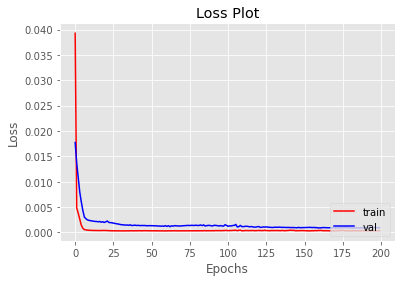

In [24]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.06359365252316539
MSE = 0.005325811967635652
RMSE = 0.07297816089513116
R2-Score = 0.7626704945070175


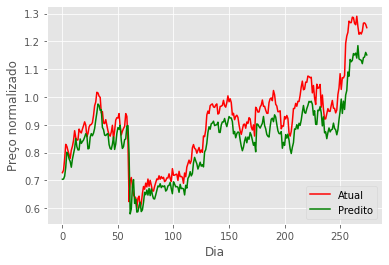

In [25]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [26]:
# Save a model
model.save('RNN-M_30_[50,45]_1e-3_32.h5')
del model  #Deletes the model
# Load a model
model = load_model('RNN-M_30_[50,45]_1e-3_32.h5')

## Cross Validation

In [38]:
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 32
num_epochs = 100

In [39]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2462, 4)
            Adj_close       Open        Low       High
Date                                                  
2021-12-23  30.440001  30.350000  30.180000  30.680000
2021-12-27  31.040001  30.440001  30.240000  31.230000
2021-12-28  31.059999  31.260000  31.000000  31.469999
2021-12-29  30.950001  31.010000  30.750000  31.340000
2021-12-30  30.700001  30.950001  30.549999  31.129999


In [40]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.4742555 , 0.63887861, 0.64699372, 0.65066763],
       [0.47826171, 0.6606418 , 0.66027298, 0.66005053],
       [0.4742555 , 0.67170787, 0.66728148, 0.66113313],
       ...,
       [0.9815069 , 0.93581705, 0.93434161, 0.91952359],
       [0.97743846, 0.92659536, 0.92511992, 0.91483217],
       [0.96819191, 0.92438218, 0.91774254, 0.90725364]])

### Split I

In [41]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.03853215551297044
MSE = 0.0021369535433646536
RMSE = 0.04622719484637429
R-Squared Score = 0.7625604401443671


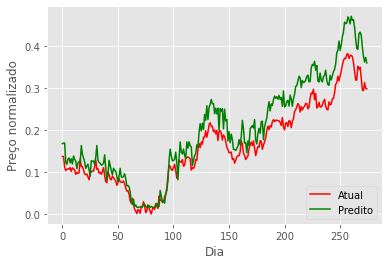

In [42]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split1.h5")

### Split II

Split 2
MAE = 0.06620277804550787
MSE = 0.004658997370727805
RMSE = 0.0682568485261941
R-Squared Score = -0.6104359450027868


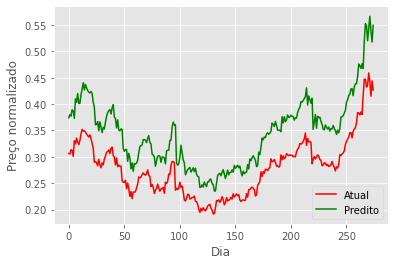

In [43]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split2.h5")

### Split III

Split 3
MAE = 0.11513074252121289
MSE = 0.014495728920299615
RMSE = 0.1203982097885995
R-Squared Score = -0.016744510114526046


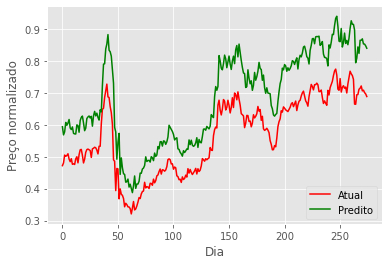

In [44]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split3.h5")

### Split IV

Split 4
MAE = 0.12105387365191062
MSE = 0.016698847071983384
RMSE = 0.12922401894378377
R-Squared Score = 0.3999932297198673


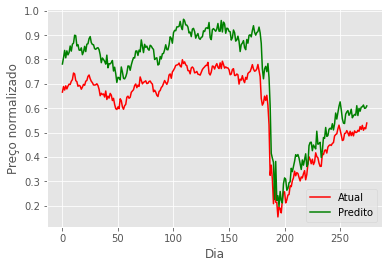

In [45]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split4.h5")

### Split V

Split 5
MAE = 0.08995101302119982
MSE = 0.008999609957071653
RMSE = 0.09486627407604693
R-Squared Score = 0.25328542301081813


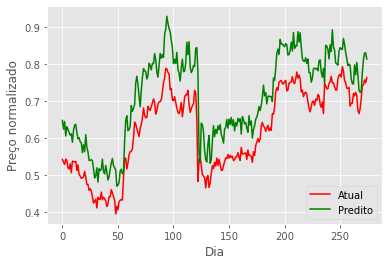

In [46]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-RNN-Split5.h5")

In [47]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.08617411255056033
Avg. MSE = 0.00939802737268942
Avg. RMSE = 0.09179450923619972
Avg. R2-score = 0.15773172755154793


In [48]:
CV_results.to_csv('RNN-M PETR3.csv')
# train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
# val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')